#  Bibliotecas

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# Common imports
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

## Funções 

In [3]:
# Para gráficos e figuras:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Onde salvar as figuras
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "primeira_parte"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="svg"):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension)

# para importar dados:  
DATASET_PATH = os.path.join("datasets")

def load_mackeyglass_data(dataset_path=DATASET_PATH):
    csv_path = os.path.join(dataset_path, "mackeyglass.csv")
    return pd.read_csv(csv_path)

# Para separar conjuntos de treinamento:
def split_train_test(data, test_ratio): # separa dados de teste (mais recentes) e de treinamento
    test_set_size = int(len(data) * test_ratio) # define tamanho do conjunto de teste
    train_set_size = len(data) - test_set_size # calcula tamanho do conjunto de treinamento
    return data.iloc[:train_set_size], data.iloc[train_set_size:] # retorna conjunto de treinamento e de dados, respectivamente

# Primeira Parte: Sistema de Mackey-Glass

In [4]:
# to make this notebook's output stable across runs
np.random.seed(42)

### Importando e interpretando os dados

In [5]:
mackeyglass = load_mackeyglass_data()
mackeyglass.head()

,t,p
0,0.0,0.188921
1,1.0,0.190910
2,2.0,0.194433
3,3.0,0.199178
4,4.0,0.204882


In [6]:
mackeyglass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       5000 non-null   float64
 1   p       5000 non-null   float64
dtypes: float64(2)
memory usage: 78.2 KB


In [7]:
mackeyglass.describe()

,t,p
count,5000.000000,5000.000000
mean,2499.500000,0.908258
std,1443.520003,0.263595
min,0.000000,0.188921
25%,1249.750000,0.746241
50%,2499.500000,0.944711
75%,3749.250000,1.109743
max,4999.000000,1.366951


Saving figure mackeyglass


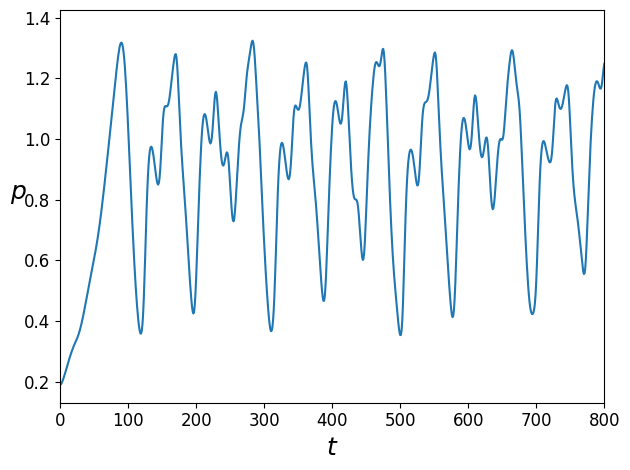

In [8]:
t = mackeyglass['t'].to_numpy()
p = mackeyglass['p'].to_numpy()

plt.plot(t, p)
plt.xlabel("$t$", fontsize=18)
plt.ylabel("$p$", rotation=0, fontsize=18)
plt.xlim(0,800)
save_fig("mackeyglass")
plt.show()

### Conjunto de teste

In [9]:
train_set, test_set = split_train_test(mackeyglass, .15)
train_set

,t,p
0,0.0,0.188921
1,1.0,0.190910
2,2.0,0.194433
3,3.0,0.199178
4,4.0,0.204882
...,...,...
4245,4245.0,1.131059
4246,4246.0,1.110181
4247,4247.0,1.085578
4248,4248.0,1.059587


### Conjunto de Validação

In [10]:
train_set, validation_set = split_train_test(train_set, .2)
validation_set

,t,p
3400,3400.0,0.713371
3401,3401.0,0.781323
3402,3402.0,0.837873
3403,3403.0,0.882391
3404,3404.0,0.915489
...,...,...
4245,4245.0,1.131059
4246,4246.0,1.110181
4247,4247.0,1.085578
4248,4248.0,1.059587


### Montagem das matrizes 

In [11]:
L = 7 # horizonte de predição

In [12]:
def monta_matrizes(dataset, K, L=L):            
    t = dataset['t'].to_numpy()  
    p = dataset['p'].to_numpy()
    y_size = len(dataset) - (L+K-1) # número de linhas da matriz y
    y = p[(L+K-1):] # matriz y: valores de p[L+K-1:(end)]
    x = np.array([np.append(np.array([1]),p[0:K])]) # cria primeira linha da matrix x 
    x = np.flip(x,1) # espelha primeira linha da matriz
    for i in np.arange(1, y_size, 1):    # cria uma linha nova de x a cada iteração (y_size iterações)
        c_aux = [np.append(np.array([1]),p[i:K+i])]  # cria a coluna de p[i] até p[K+i-1]
        c = np.flip(c_aux,1)   # espelha a linha
        x = np.concatenate((x, c)) # adiciona linha à matriz 
    t_y = t[(L+K-1):] # valores de t das saídas y(t)
    return t_y, x, y
    
def new_matrices(K, new_set, dataset=mackeyglass, L=L):
    t = dataset['t'].to_numpy() # separa t e p do dataset original (mackeyglass)
    p = dataset['p'].to_numpy()
    t_new = new_set['t'].to_numpy() # separa colunas 't' e 'p' do conjunto de validação
    y_new = new_set['p'].to_numpy()
    x_new = np.array([np.append(np.array([1]),p[int(t_new[0])-L-K:int(t_new[0])-L])]) # cria primeira linha da matrix x 
    x_new = np.flip(x_new,1) # espelha primeira linha da matriz    
    for i in np.arange(1, len(y_new), 1):    # cria uma linha nova de x a cada iteração 
        c_aux = [np.append(np.array([1]),p[int(t_new[0])-L+i-K:int(t_new[0])-L+i])]  # cria nova coluna
        c = np.flip(c_aux,1)  # espelha a linha
        x_new = np.concatenate((x_new, c)) # adiciona linha à matriz
    return t_new, x_new, y_new

In [13]:
t_y, x, y=monta_matrizes(train_set, 10,L)
print(x)
print(x.shape)
print(y)
print(len(y))

[[0.24099693 0.23326116 0.22565703 ... 0.19091041 0.188921   1.        ]
 [0.24877041 0.24099693 0.23326116 ... 0.19443267 0.19091041 1.        ]
 [0.25650438 0.24877041 0.24099693 ... 0.19917811 0.19443267 1.        ]
 ...
 [0.35774147 0.37825901 0.40270067 ... 0.60009946 0.6419454  1.        ]
 [0.34239737 0.35774147 0.37825901 ... 0.5614275  0.60009946 1.        ]
 [0.33395374 0.34239737 0.35774147 ... 0.52546386 0.5614275  1.        ]]
(3384, 11)
[0.29277651 0.29932678 0.30560142 ... 0.48311315 0.55749102 0.63685591]
3384


In [14]:
t_new_val, x_new_val, y_new_val = new_matrices(10, validation_set)
print(x_new_val)
print(x_new_val.shape)
print(y_new_val)
print(len(y_new_val))

[[0.33395374 0.34239737 0.35774147 ... 0.52546386 0.5614275  1.        ]
 [0.33474875 0.33395374 0.34239737 ... 0.49173373 0.52546386 1.        ]
 [0.34769114 0.33474875 0.33395374 ... 0.45995003 0.49173373 1.        ]
 ...
 [1.05744647 1.02268639 0.99574469 ... 1.01818471 1.03164726 1.        ]
 [1.09386658 1.05744647 1.02268639 ... 1.00356256 1.01818471 1.        ]
 [1.12460883 1.09386658 1.05744647 ... 0.98973777 1.00356256 1.        ]]
(850, 11)
[0.71337077 0.78132327 0.83787346 0.88239113 0.91548906 0.93831071
 0.95212111 0.95811594 0.95736978 0.9508619  0.93953427 0.92434502
 0.90631498 0.88657427 0.86642781 0.84744294 0.83154206 0.82103946
 0.81852923 0.82650861 0.8467006  0.87918449 0.92156539 0.96865655
 1.01364505 1.05081252 1.07768649 1.09496831 1.1051338  1.11114589
 1.11574908 1.12117616 1.12903232 1.14023673 1.15499352 1.17284636
 1.19282687 1.21371411 1.23434015 1.25384321 1.27176711 1.28788728
 1.30168224 1.31143512 1.31344848 1.3028786  1.277033   1.23787242
 1.1904248

In [15]:
t_new_test, x_new_test, y_new_test = new_matrices(10, test_set)
print(x_new_test)
print(x_new_test.shape)
print(y_new_test)
print(len(y_new_test))

[[1.14420483 1.12460883 1.09386658 ... 0.97920398 0.98973777 1.        ]
 [1.15080405 1.14420483 1.12460883 ... 0.97490661 0.97920398 1.        ]
 [1.14555785 1.15080405 1.14420483 ... 0.97976703 0.97490661 1.        ]
 ...
 [1.25556151 1.25076952 1.23863536 ... 1.13372355 1.12325683 1.        ]
 [1.24871452 1.25556151 1.25076952 ... 1.14802839 1.13372355 1.        ]
 [1.22704509 1.24871452 1.25556151 ... 1.16531061 1.14802839 1.        ]]
(750, 11)
[1.01141902 0.99259252 0.97899809 0.97140715 0.97000171 0.97422981
 0.98269457 0.99314863 1.00255771 1.00723215 1.00324435 0.98762555
 0.96013171 0.92375906 0.88319305 0.84289272 0.80632044 0.77601782
 0.75384878 0.74109619 0.73837054 0.74542645 0.7610611  0.78323729
 0.80942457 0.83699822 0.86353845 0.88700361 0.90587435 0.91936884
 0.92773768 0.93251529 0.93661475 0.9440314  0.95878711 0.9830423
 1.01559277 1.05247491 1.08925455 1.12288867 1.1521836  1.17736598
 1.1994466  1.21964596 1.23892936 1.25764921 1.27538084 1.2910197
 1.30318981 

## Regressão Linear

In [16]:
#lin_reg = LinearRegression()

In [21]:
def reg_lin(x,y):
    theta_best = np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)
    return theta_best

In [22]:
def predict(theta_best, X_new):
    y_predict = X_new.dot(theta_best)
    return y_predict

### Erro quadrático médio (RMSE)

In [23]:
def rmse(y, y_predict):  # calcula erro quadrático médio
    e = y - y_predict # erro entre estimado e real
    rmse = np.sqrt(sum(e**2)/len(e)) # erro quadrático médio
    return rmse

#np.sqrt(sklearn.metrics.mean_squared_error(y, y_predict)) # rmse pelo scikit learn

## Validação Cruzada

In [24]:
rmse_matrix = [] # RMSE para cada valor de K na validação 
rmse_matrix_train = [] # RMSE para cada valor de K no treinamento

K_max = 50

for K in np.arange(1,K_max+1,1): # realiza a regressão linear para K = 1 a 50 e calcula o RMSE para os conjuntos de treinamento e de teste
    t_y, x, y = monta_matrizes(train_set, K) # monta matrizes para treinamento
    #lin_reg.fit(x, y) # fit com matrizes de treinamento
    theta_best = reg_lin(x,y)
    t_val, x_val, y_val = new_matrices(K, validation_set) # monta matrizes para validação
   # y_predict = lin_reg.predict(x_val) # estima valores do conjunto de validação com coeficientes obtidos no treinamento
    #y_predict_train = lin_reg.predict(x) # estima valores do conjunto de treinamento
    y_predict = predict(theta_best, x_val)
    y_predict_train = predict(theta_best, x)
    rmse_matrix = np.append(rmse_matrix, rmse(y_val, y_predict)) # calcula o RMSE da validação para cada valor de K
    rmse_matrix_train = np.append(rmse_matrix_train, rmse(y, y_predict_train))
   # print(rmse_matrix)

Saving figure validation


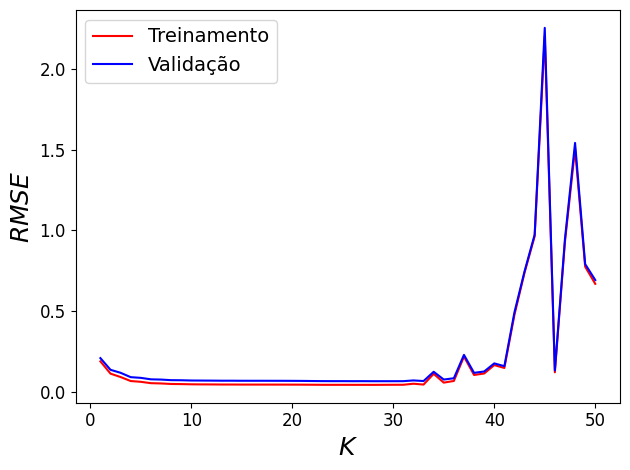

In [25]:
# gráfico do RMSE para cada K nos conjuntos de treinamento e validação
plt.plot(np.arange(1,K_max+1,1), rmse_matrix_train, "r-", label = "Treinamento")
plt.plot(np.arange(1,K_max+1,1), rmse_matrix, "b-", label = "Validação")
plt.xlabel("$K$", fontsize=18)
plt.ylabel("$RMSE$", rotation=90, fontsize=18)
plt.legend(loc="best", fontsize=14)
save_fig("validation")
plt.show()

In [26]:
print(rmse_matrix[45:])
rmse_min = np.min(rmse_matrix)
rmse_min_index = np.where(rmse_matrix == rmse_min)
print(rmse_min_index)
print(rmse_min)

# melhor K: 50

[0.1332581  0.94677405 1.54136141 0.79138743 0.69267324]
(array([27], dtype=int64),)
0.06635060029303164


Saving figure teste


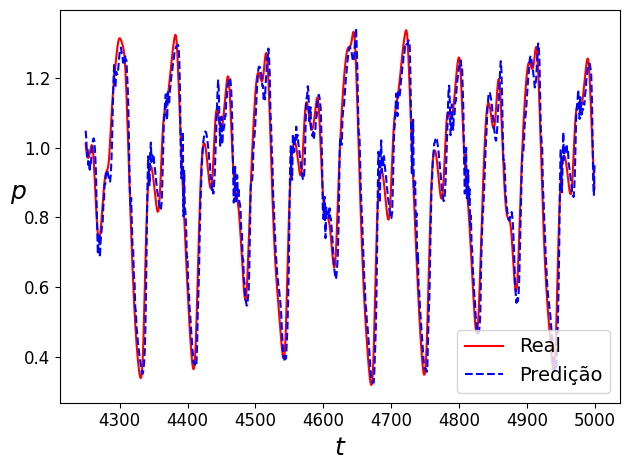

In [28]:
# Estimativa com K=27 (erro mínimo) para conjunto de teste 
t_y, x, y = monta_matrizes(train_set, K=27)
#lin_reg.fit(x, y) # fit com matrizes de treinamento
theta_best = reg_lin(x,y)
t_test, x_test, y_test = new_matrices(27, test_set) 
#y_predict = lin_reg.predict(x_test) # estima valores do conjunto de teste com coeficientes obtidos no treinamento
y_predict = predict(theta_best, x_test)

# gráfico com amostras de teste e estimativas com K = 50 (erro mínimo)
plt.plot(t_test, y_test, "r-", label = "Real")
plt.plot(t_test, y_predict, "b--", label = "Predição")
plt.xlabel("$t$", fontsize=18)
plt.ylabel("$p$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.legend(loc="best", fontsize=14)
save_fig("teste")
plt.show()

# Segunda Parte: Transformações não lineares

In [54]:
# Criação da matriz x que será multiplicada por W_k
# Utiliza-se as mesmas funções do item anterior para a criação da matriz x, mas sem a coluna de uns
# Essa função recebe o conjunto p a ser transformado e seu vetor temporal
def cria_matriz_x(p,t, K, L=L):            
    y_size = len(p) - (L+K-1) # número de linhas da matriz y
    y = p[(L+K-1):] # matriz y: valores de p[L+K-1:(end)]
    x = np.array([p[0:K]]) # cria primeira linha da matrix x 
    x = np.flip(x,1) # espelha primeira linha da matriz
    for i in np.arange(1, y_size, 1):    # cria uma linha nova de x a cada iteração (y_size iterações)
        c_aux = [p[i:K+i]]  # cria a coluna de p[i] até p[K+i-1]
        c = np.flip(c_aux,1)   # espelha a linha
        x = np.concatenate((x, c)) # adiciona linha à matriz 
    t_y = t[(L+K-1):] # valores de t das saídas y(t)
    return t_y, x, y
# Criação da matriz x para o conjunto de validação e teste sem a coluna de uns
# Essa função recebe o conjunto completo p_c e seu vetor temporal
# Recebe também o conjunto novo no qual se deseja transforma em matrizes
def cria_nova_matriz(K, p_c, t_c, y_new, t_new,L=L):
    x_new = np.array([p_c[int(t_new[0])-L-K:int(t_new[0])-L]]) # cria primeira linha da matrix x 
    x_new = np.flip(x_new,1) # espelha primeira linha da matriz    
    for i in np.arange(1, len(y_new), 1):    # cria uma linha nova de x a cada iteração 
        c_aux = [p_c[int(t_new[0])-L+i-K:int(t_new[0])-L+i]]  # cria nova coluna
        c = np.flip(c_aux,1)  # espelha a linha
        x_new = np.concatenate((x_new, c)) # adiciona linha à matriz
    return t_new, x_new, y_new

In [55]:
def ridge(x,y,V, alpha):
    I=np.eye(K)
    I[0][0] = 0
    theta_best_r = np.linalg.inv(x.T.dot(x)+I*alpha).dot(x.T).dot(y)
    return theta_best_r
def predict_ridge(theta_best_r, X_new):
    y_predict_r = X_new.dot(theta_best_r)
    return y_predict_r

In [56]:
# A função tangente hiperbólica para valores grandes retorna sempre valor 1, isso não é bom para o modelo
# Para corrigir isso há a necessidade de uma normalização dos dados para que os valores não passem de 2
# A padronização data standardization coloca os valores em torno de 0.
# Funções de normalização e desnormalização:
def padronizacao(dados, conjunto_inicial):
    media = np.mean(conjunto_inicial)
    desvio_p = np.std(conjunto_inicial)
    p_pad=((dados-media)*0.1)/desvio_p
    return p_pad
def padronizacao_inversa(dados_norm, conjunto_inicial):
    media = np.mean(conjunto_inicial)
    desvio_p = np.std(conjunto_inicial)
    x_invpad=((dados_norm)*(desvio_p)/0.1)+media
    return x_invpad

In [57]:
# Convertendo os conjuntos para numpy
t_c = mackeyglass['t'].to_numpy()
p_c = mackeyglass['p'].to_numpy()
t_train = train_set['t'].to_numpy()  
p_train = train_set['p'].to_numpy()
t_validation = validation_set['t'].to_numpy()  
p_validation = validation_set['p'].to_numpy()
t_test = test_set['t'].to_numpy()  
p_test = test_set['p'].to_numpy()
print(len(p_c))
print(len(p_train))
print(len(p_validation))
print(len(p_test))
print(p_c)

5000
3400
850
750
[0.188921   0.19091041 0.19443267 ... 0.95532904 0.91667659 0.88250231]


In [58]:
# Normalização dos conjuntos de treinamento, validação e teste
p_c_n = padronizacao(p_c,p_c)   # normalização do conjunto total
p_t_n = padronizacao(p_train,p_c)  # treino normalizado
p_v_n=padronizacao(p_validation,p_c)  # validação normalizado
p_tt_n=padronizacao(p_test,p_c)     # teste normalizado
print(p_c_n)
print(len(p_c_n))
print(p_t_n)
print(len(p_t_n))
print(p_v_n)
print(len(p_v_n))
print(p_tt_n)
print(len(p_tt_n))
print(np.max(p_t_n))
print(np.min(p_t_n))
print(np.max(p_v_n))
print(np.min(p_v_n))
print(np.max(p_tt_n))
print(np.min(p_tt_n))

[-0.27292176 -0.27216696 -0.27083059 ...  0.01785923  0.00319419
 -0.00977178]
5000
[-0.27292176 -0.27216696 -0.27083059 ... -0.16130304 -0.13308352
 -0.10297188]
3400
[-7.39415670e-02 -4.81598744e-02 -2.67043072e-02 -9.81396943e-03
  2.74363462e-03  1.14023432e-02  1.66421099e-02  1.89165939e-02
  1.86334952e-02  1.61643588e-02  1.18665701e-02  6.10365408e-03
 -7.37079662e-04 -8.22685246e-03 -1.58705709e-02 -2.30735757e-02
 -2.91064885e-02 -3.30912552e-02 -3.40436542e-02 -3.10162154e-02
 -2.33552247e-02 -1.10305926e-02  5.04904127e-03  2.29157826e-02
  3.99847588e-02  5.40863778e-02  6.42825634e-02  7.08394167e-02
  7.46962807e-02  7.69773116e-02  7.87237971e-02  8.07828721e-02
  8.37635562e-02  8.80145955e-02  9.36134345e-02  1.00386934e-01
  1.07967689e-01  1.15892467e-01  1.23718142e-01  1.31117750e-01
  1.37918214e-01  1.44034328e-01  1.49268238e-01  1.52968555e-01
  1.53732439e-01  1.49722145e-01  1.39916129e-01  1.25058312e-01
  1.07056346e-01  8.78211846e-02  6.87002998e-02  5.

In [59]:
L=7
# Matriz x de treino normalizada
t_t_n, x_t_n, y_t_n=cria_matriz_x(p_t_n, t_train, 10,L)
print(x_t_n)
print(x_t_n.shape)
print(y_t_n)
print(len(y_t_n))
print(np.min(y_t_n))
print(np.max(y_t_n))
print(np.min(x_t_n))
print(np.max(x_t_n))

[[-0.25316376 -0.25609877 -0.25898384 ... -0.27083059 -0.27216696
  -0.27292176]
 [-0.25021444 -0.25316376 -0.25609877 ... -0.26903014 -0.27083059
  -0.27216696]
 [-0.24728012 -0.25021444 -0.25316376 ... -0.26686605 -0.26903014
  -0.27083059]
 ...
 [-0.20887    -0.20108549 -0.19181214 ... -0.13158999 -0.11691755
  -0.10104089]
 [-0.21469167 -0.20887    -0.20108549 ... -0.14523486 -0.13158999
  -0.11691755]
 [-0.21789525 -0.21469167 -0.20887    ... -0.15803233 -0.14523486
  -0.13158999]]
(3384, 10)
[-0.2335182  -0.23103298 -0.22865233 ... -0.16130304 -0.13308352
 -0.10297188]
3384
-0.23351819595750364
0.17403169090257212
-0.27292176010312635
0.17403169090257212


In [60]:
L=7
# Matriz x de validação normalizada
t_v_n, x_v_n, y_v_n = cria_nova_matriz(10, p_c_n, t_c, p_v_n, t_validation ,L)
print(x_v_n)
print(x_v_n.shape)
print(y_v_n)
print(len(y_v_n))
print(np.max(y_v_n))
print(np.min(y_v_n))

[[-0.21789525 -0.21469167 -0.20887    ... -0.15803233 -0.14523486
  -0.13158999]
 [-0.21759361 -0.21789525 -0.21469167 ... -0.1700913  -0.15803233
  -0.14523486]
 [-0.21268317 -0.21759361 -0.21789525 ... -0.18139791 -0.1700913
  -0.15803233]
 ...
 [ 0.05660335  0.04341511  0.03319323 ...  0.03615939  0.04170714
   0.04681493]
 [ 0.07042141  0.05660335  0.04341511 ...  0.03091416  0.03615939
   0.04170714]
 [ 0.08208525  0.07042141  0.05660335 ...  0.02691756  0.03091416
   0.03615939]]
(850, 10)
[-7.39415670e-02 -4.81598744e-02 -2.67043072e-02 -9.81396943e-03
  2.74363462e-03  1.14023432e-02  1.66421099e-02  1.89165939e-02
  1.86334952e-02  1.61643588e-02  1.18665701e-02  6.10365408e-03
 -7.37079662e-04 -8.22685246e-03 -1.58705709e-02 -2.30735757e-02
 -2.91064885e-02 -3.30912552e-02 -3.40436542e-02 -3.10162154e-02
 -2.33552247e-02 -1.10305926e-02  5.04904127e-03  2.29157826e-02
  3.99847588e-02  5.40863778e-02  6.42825634e-02  7.08394167e-02
  7.46962807e-02  7.69773116e-02  7.87237971

In [61]:
# Teste desnormalização
#x_pad=padronizacao_inversa(x_t_n,p_c)
y_pad=padronizacao_inversa(y_v_n,p_c)
print(y_pad)
print(y_pad.shape)

[0.71337077 0.78132327 0.83787346 0.88239113 0.91548906 0.93831071
 0.95212111 0.95811594 0.95736978 0.9508619  0.93953427 0.92434502
 0.90631498 0.88657427 0.86642781 0.84744294 0.83154206 0.82103946
 0.81852923 0.82650861 0.8467006  0.87918449 0.92156539 0.96865655
 1.01364505 1.05081252 1.07768649 1.09496831 1.1051338  1.11114589
 1.11574908 1.12117616 1.12903232 1.14023673 1.15499352 1.17284636
 1.19282687 1.21371411 1.23434015 1.25384321 1.27176711 1.28788728
 1.30168224 1.31143512 1.31344848 1.3028786  1.277033   1.23787242
 1.19042485 1.13972696 1.08933027 1.04119787 0.99603894 0.95367203
 0.91335774 0.87410926 0.83499691 0.7953934  0.75510451 0.71434318
 0.67359149 0.63342326 0.59436283 0.55681888 0.52109863 0.48750216
 0.45647847 0.42880878 0.4057497  0.38910103 0.38118972 0.38467205
 0.40197223 0.43438558 0.48130463 0.54014175 0.60699016 0.67751464
 0.74759679 0.81367668 0.87294504 0.92347235 0.96423723 0.99502174
 1.01620052 1.0285203  1.03292047 1.03041422 1.02204484 1.0089

In [62]:
# Matriz x de teste normalizada
t_tt_n, x_tt_n, y_tt_n = cria_nova_matriz(10, p_c_n, t_c, p_tt_n, t_test, L)
print(x_tt_n)
print(x_tt_n.shape)
print(y_tt_n)
print(len(y_tt_n))
print(np.max(y_tt_n))
print(np.min(y_tt_n))

[[0.08952012 0.08208525 0.07042141 ... 0.0252871  0.02691756 0.03091416]
 [0.09202392 0.08952012 0.08208525 ... 0.02713118 0.0252871  0.02691756]
 [0.09003347 0.09202392 0.08952012 ... 0.03319323 0.02713118 0.0252871 ]
 ...
 [0.13176969 0.12995157 0.12534778 ... 0.09097081 0.08554345 0.08157229]
 [0.12917188 0.13176969 0.12995157 ... 0.09752781 0.09097081 0.08554345]
 [0.12095034 0.12917188 0.13176969 ... 0.1047507  0.09752781 0.09097081]]
(750, 10)
[ 0.03914019  0.03199727  0.02683944  0.02395938  0.02342615  0.02503032
  0.02824191  0.03220826  0.03577814  0.03755166  0.03603866  0.03011277
  0.01968139  0.00588134 -0.00950972 -0.02479996 -0.03867576 -0.0501728
 -0.05858391 -0.06342233 -0.06445647 -0.0617794  -0.05584749 -0.04743368
 -0.03749803 -0.02703638 -0.01696682 -0.00806396 -0.00090426  0.00421565
  0.00739086  0.00920352  0.01075888  0.01357281  0.01917124  0.02837385
  0.04072374  0.0547171   0.06867157  0.08143261  0.09254733  0.10210171
  0.11047927  0.11814306  0.12545932

## Validação cruzada sem Ridge Regression

In [63]:
# Hiperparâmtro K fixo em 10
K=10
# Horizonte de predição continua 7
L=7
rmse_matrix2 = [] # RMSE para cada valor de K na validação 
rmse_matrix_train2 = [] # RMSE para cada valor de K no treinamento
V_max = 100
for V in np.arange(1,V_max+1,1): # realiza a regressão linear para V = 1 a 101 e calcula o RMSE para os conjuntos de treinamento e de teste
    # Vetores de pesos aleatórios, matriz (VxK)
    W_k = np.random.uniform(low=0.0, high=1.0, size=(V,K))

    # Matriz x de treino normalizada
    t_t_n, x_t_n, y_t_n=cria_matriz_x(p_t_n, t_train, 10,L)
    #produto da matrizes Wt*X deve ter dimensão (VxN), como Wk é (VxK), é preciso que X tenha dimensão (KxN)
    # Por isso o uso de X transposto
    # Para a matriz de treinamento:
    prod_train = np.dot(W_k,x_t_n.T)
    x_e_train = np.tanh(prod_train)
    # Adicionando a linha de uns
    one_train = np.ones(shape=(len(y_t_n)))
    arow_train=np.r_[[one_train]]
    x_transf_train=np.concatenate((x_e_train,arow_train),axis=0)  # Matriz que vai pra regressão

    # Matriz x de validação normalizada
    t_v_n, x_v_n, y_v_n = cria_nova_matriz(10, p_c_n, t_c, p_v_n, t_validation ,L)
    # Para a matriz de validação:
    prod_validation = np.dot(W_k,x_v_n.T)
    x_e_validation = np.tanh(prod_validation)
    # Adicionando a linha de uns
    one_validation = np.ones(shape=(len(y_v_n)))
    arow_validation=np.r_[[one_validation]]
    x_transf_validation=np.concatenate((x_e_validation,arow_validation),axis=0)  # Matriz que vai pra regressão

    # Regressão
    # Para a regressão é necessário transpor novamente a matriz X
    #lin_reg.fit(x_transf_train.T, y_t_n) # fit com matrizes de treinamento
    theta_best2 = reg_lin(x_transf_train.T,y_t_n)
    y_predict_val2 = predict(theta_best2, x_transf_validation.T)
    y_predict_train2 = predict(theta_best2, x_transf_train.T)
    #y_predict_val2 = lin_reg.predict(x_transf_validation.T) # estima valores do conjunto de validação com coeficientes obtidos no treinamento
    #y_predict_train2 = lin_reg.predict(x_transf_train.T) # estima valores do conjunto de treinamento
    y_predict_val_d=desnormalizacao(y_predict_val2,p_c)  # desnormalizando os valores previstos de validação
    y_predict_train_d=desnormalizacao(y_predict_train2,p_c)  # desnormalizando os valores previstos de teste
    y_val_d=desnormalizacao(y_v_n,p_c)  # desnormalizando os valores previstos de validação
    y_train_d=desnormalizacao(y_t_n,p_c)  # desnormalizando os valores previstos de teste
    rmse_matrix2 = np.append(rmse_matrix2, rmse(y_val_d, y_predict_val_d)) # calcula o RMSE da validação para cada valor de K com os valores desnormalizados
    rmse_matrix_train2 = np.append(rmse_matrix_train2, rmse(y_train_d, y_predict_train_d)) # calcula o RMSE do treinamento para cada valor de K com os valores desnormalizados

Saving figure validation2


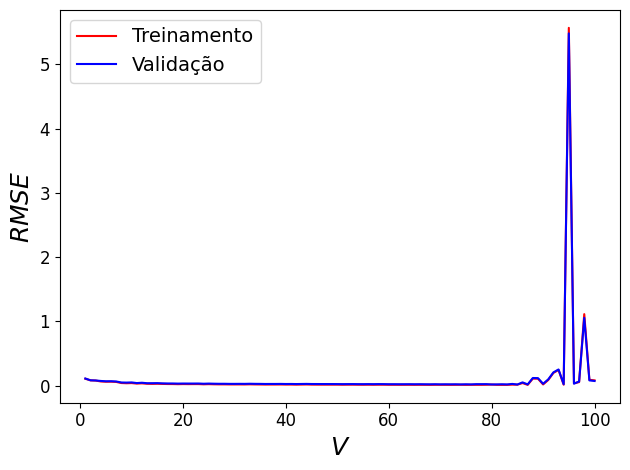

In [64]:
# gráfico do RMSE para cada V nos conjuntos de treinamento e validação para a questão 2 sem ridge
plt.plot(np.arange(1,V_max+1,1), rmse_matrix_train2, "r-", label = "Treinamento")
plt.plot(np.arange(1,V_max+1,1), rmse_matrix2, "b-", label = "Validação")
plt.xlabel("$V$", fontsize=18)
plt.ylabel("$RMSE$", rotation=90, fontsize=18)
plt.legend(loc="best", fontsize=14)
save_fig("validation2")
plt.show()

In [65]:
print(rmse_matrix2[45:])
rmse_min2 = np.min(rmse_matrix2)
rmse_min_index2 = np.where(rmse_matrix2 == rmse_min2)
print(rmse_min_index2)
print(rmse_min2)

# melhor K: 50

[0.02420686 0.02390846 0.02380158 0.02372268 0.023316   0.02247956
 0.02306281 0.0233209  0.02236453 0.02194535 0.02286751 0.02204372
 0.02321199 0.02256838 0.02130878 0.02134703 0.02096071 0.02105504
 0.0214809  0.02071461 0.02131162 0.02031655 0.01981074 0.02105862
 0.01927736 0.02019255 0.01951778 0.02022829 0.01816605 0.02036665
 0.01847734 0.02216635 0.02194364 0.02234675 0.01737311 0.0185149
 0.0204197  0.01820538 0.02577328 0.01672899 0.04995829 0.01877636
 0.11793038 0.1160882  0.02837479 0.09696267 0.20532094 0.25073919
 0.0210465  5.48011961 0.0297204  0.06358837 1.05431883 0.08085517
 0.07154006]
(array([84], dtype=int64),)
0.016728989766568593


## Ridge Regression e teste para diferentes V

In [66]:
#Hiperparâmtro K fixo em 10
K=10
# Horizonte de predição continua 7
L=7
# Vetor de valores de alfa
alpha_vector=[1000, 100, 10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 0]
rmse_matrixR = [] # RMSE para cada valor de K na validação 
rmse_matrix_trainR = [] # RMSE para cada valor de K no treinamento
Best_alpha_train = []  # Melhores alfas para cada V no treinamento
best_rmse_alpha_train =[]   # RMSE para os melhores alfas para cada V no treinamento
Best_alpha_val = []  # Melhores alfas para cada V na validação
best_rmse_alpha_val =[]   # RMSE para os melhores alfas para cada V na validação
V_max = 1000
for V in np.arange(1,V_max+1,10): # realiza a regressão linear para V = 1 a 101 e calcula o RMSE para os conjuntos de treinamento e de teste
    # Vetores de pesos aleatórios, formam uma matriz (VxK)
    W_k = (np.random.uniform(low=0.0, high=1.0, size=(V,K)))

    # Matriz x de treino normalizada
    t_t_n, x_t_n, y_t_n=cria_matriz_x(p_t_n, t_train, K ,L)
    #produto da matrizes Wt*X deve ter dimensão (VxN), como Wk é (VxK), é preciso que X tenha dimensão (KxN)
    # Por isso o uso de X transposto
    # Para a matriz de treinamento:
    prod_train = np.dot(W_k,x_t_n.T)
    x_e_train = np.tanh(prod_train)
    # Adicionando a linha de uns
    one_train = np.ones(shape=(len(y_t_n)))
    arow_train=np.r_[[one_train]]
    x_transf_train=np.concatenate((x_e_train,arow_train),axis=0)  # Matriz que vai pra regressão

    # Matriz x de validação normalizada
    t_v_n, x_v_n, y_v_n = cria_nova_matriz(K, p_c_n, t_c, p_v_n, t_validation ,L)
    # Para a matriz de validação:
    prod_validation = np.dot(W_k,x_v_n.T)
    x_e_validation = np.tanh(prod_validation)
    # Adicionando a linha de uns
    one_validation = np.ones(shape=(len(y_v_n)))
    arow_validation=np.r_[[one_validation]]
    x_transf_validation=np.concatenate((x_e_validation,arow_validation),axis=0)  # Matriz que vai pra regressão
    # Regressão com Ridge:
    for alpha in alpha_vector:
        #ridge_reg=Ridge(alpha, fit_intercept = True)
        #ridge_reg.fit(x_transf_train,y_t_n)
        theta_best_r = ridge(x_transf_train.T, y_t_n, V, alpha)
        y_predict_valR = predict_ridge(theta_best_r, x_transf_validation.T)
        y_predict_trainR = predict_ridge(theta_best_r, x_transf_train.T)
       # y_predict_val2 = ridge_reg.predict(x_transf_validation) # estima valores do conjunto de validação com coeficientes obtidos no treinamento
        #y_predict_train2 = ridge_reg.predict(x_transf_train) # estima valores do conjunto de treinamento
        y_predict_valR_d=padronizacao_inversa(y_predict_valR,p_c)  # desnormalizando os valores de validação
        y_predict_trainR_d=padronizacao_inversa(y_predict_trainR,p_c)  # desnormalizando os valores de teste
        rmse_matrixR = np.append(rmse_matrixR, rmse(y_valR_d, y_predict_valR_d)) # calcula o RMSE da validação para cada valor de alpha
        rmse_matrix_trainR = np.append(rmse_matrix_trainR, rmse(y_trainR_d, y_predict_trainR_d)) # calcula o RMSE do treinamento para cada valor de alpha
    best_rmse_alpha_train.append(np.min(rmse_matrix_trainR[-10:])) #Pega o mínimo dos últimos 10 valores de RMSE
    Best_alpha_train.append(alpha_vector[np.argmin(rmse_matrix_trainR[-10:])]) #Pega o valor de alfa referente ao argumento mínimo dos últimos 10 valores
    best_rmse_alpha_val.append(np.min(rmse_matrixR[-10:])) #Pega o mínimo dos últimos 10 valores de RMSE para a validação
    Best_alpha_val.append(alpha_vector[np.argmin(rmse_matrixR[-10:])]) # Para a validação

ValueError: operands could not be broadcast together with shapes (2,2) (10,10) 

In [ ]:
# gráfico do melhor alfa para cada V nos conjuntos de treinamento e validação para a questão 2 com ridge
plt.plot(np.arange(1,V_max+1,10), Best_alpha_train, "r-", label = "Treinamento")
plt.plot(np.arange(1,V_max+1,10), Best_alpha_val, "b-", label = "Validação")
plt.xlabel("$V$", fontsize=18)
plt.ylabel("$alfa$", rotation=90, fontsize=18)
plt.legend(loc="best", fontsize=14)
save_fig("alfa_Ridge")
plt.show()

In [ ]:
# gráfico do RMSE para o melhor alfa de cada V nos conjuntos de treinamento e validação para a questão 2 com ridge
plt.plot(np.arange(1,V_max+1,10), best_rmse_alpha_train, "r-", label = "Treinamento")
plt.plot(np.arange(1,V_max+1,10), best_rmse_alpha_val, "b-", label = "Validação")
plt.xlabel("$V$", fontsize=18)
plt.ylabel("$RMSE$", rotation=90, fontsize=18)
plt.legend(loc="best", fontsize=14)
save_fig("validation2_Ridge")
plt.show()

In [ ]:
rmse_minR = np.min(rmse_matrixR)
rmse_min_indexR = np.where(rmse_matrixR == rmse_minR)
print(rmse_min_indexR)
print(rmse_minR)

## Estimativa para V=910 e alfa=0


In [ ]:
# Utilizando todo o conjunto de treinamento incluindo a validação
train_final, test_set = split_train_test(mackeyglass, .15)
train_final

In [ ]:
# Criando os conjuntos
t_train_final = train_final['t'].to_numpy()  
p_train_final = train_final['p'].to_numpy()
t_test = test_set['t'].to_numpy()  
p_test = test_set['p'].to_numpy()
print(len(p_train_final))
print(len(p_test))

In [ ]:
# Normalização dos conjuntos de treinamento, validação e teste
p_c_n = padronizacao(p_c,p_c)   # normalização do conjunto total
p_t_nf = padronizacao(p_train_final,p_c)  # treino normalizado
p_tt_n = padronizacao(p_test,p_c)     # teste normalizado

In [ ]:
# Hiperparâmtro K 
K=10
# Horizonte de predição
L=7
alpha=0
V=910
# Vetores de pesos aleatórios, formam uma matriz (VxK)
W_k = (np.random.uniform(low=0.0, high=1.0, size=(V,K)))

# Matriz x de treino normalizada
t_t_nf, x_t_nf, y_t_nf = cria_matriz_x(p_t_nf, t_train_final, K ,L)
#produto da matrizes Wt*X deve ter dimensão (VxN), como Wk é (VxK), é preciso que X tenha dimensão (KxN)
# Por isso o uso de X transposto
# Para a matriz de treinamento:
prod_trainf = np.dot(W_k,x_t_nf.T)
x_e_trainf = np.tanh(prod_trainf)
# Adicionando a linha de uns
one_trainf = np.ones(shape=(len(y_t_nf)))
arow_trainf=np.r_[[one_trainf]]
x_transf_trainf=np.concatenate((x_e_trainf,arow_trainf),axis=0)  # Matriz que vai pra regressão

# Matriz x de teste normalizada
t_tt_n, x_tt_n, y_tt_n = cria_nova_matriz(K, p_c_n, t_c, p_tt_n, t_test ,L)
# Para a matriz de validação:
prod_test = np.dot(W_k,x_tt_n.T)
x_e_test = np.tanh(prod_test)
# Adicionando a linha de uns
one_test = np.ones(shape=(len(y_tt_n)))
arow_test=np.r_[[one_test]]
x_transf_test=np.concatenate((x_e_test,arow_test),axis=0)  # Matriz que vai pra regressão
# Regressão com Ridge:
#ridge_reg=Ridge(alpha=0, fit_intercept = True)
#ridge_reg.fit(x_transf_trainf.T,y_t_nf)         # fit com matrizes de treinamento
#y_predict_trainf = ridge_reg.predict(x_transf_trainf.T) # estima valores do conjunto de treinamento completo
#y_predict_test = ridge_reg.predict(x_transf_test.T) # estima valores do conjunto de test com coeficientes obtidos no treinamento
#y_predict_trainf_d=padronizacao_inversa(y_predict_trainf,p_c)  # desnormalizando os valores previstos de treino
#y_predict_test_d=padronizacao_inversa(y_predict_test,p_c)  # desnormalizando os valores previstos de teste
 y_t_nf, V, alpha)
y_predict_trainf = predict_ridge(theta_best_rf, x_transf_trainf.T)
y_predict_test = predict_ridge(theta_best_r, x_transf_test.T)
y_predict_trainf_d=padronizacao_inversa(y_predict_trainf,p_c)  # desnormalizando os valores de validação
y_predict_test_d=padronizacao_inversa(y_predict_test,p_c)  # desnormalizando os valores de teste

# gráfico com amostras de teste e estimativas com K = 50 (erro mínimo)
plt.plot(t_test, y_test, "r-", label = "Real")
plt.plot(t_test, y_predict_test_d, "b--", label = "Predição")
plt.xlabel("$t$", fontsize=18)
plt.ylabel("$p$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.legend(loc="best", fontsize=14)
save_fig("teste_2")
plt.show()